## Evaluation metrics

REVEX also implements multiple evaluation metrics that can be used to compare XAI methods. The evaluation metrics can be grouped into:

1. Deletion and Preservation Games-based metrics.
2. Weakly supervized object localization metrics, which require object detection annotations.

In [ ]:
from matplotlib import pyplot as plt
import os
import numpy as np
import cv2

from revex_framework.pipelines import ProposedMethods
from revex_framework.xai import Xai
from revex_framework.utils import resize_video, center_crop_video, load_video, plot_frames
from revex_framework.evaluators import MinMaskEvaluator, AUCEvaluator, DropEvaluator, IOUEvaluator, PointingGameEvaluator

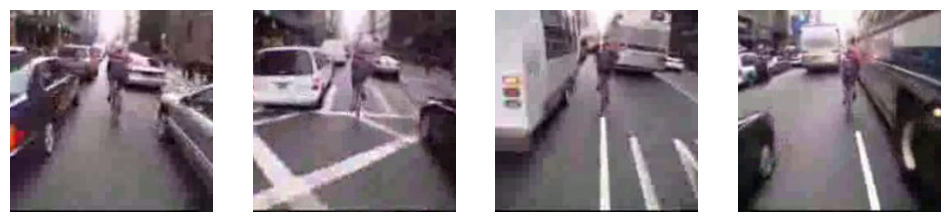

In [ ]:
# Load video
video_path = "../resources/biking.avi"
video = load_video(video_path)
scale_factor = 224 / min(video.shape[1:3])
video = resize_video(video, scale_factor, scale_factor)
video = center_crop_video(video, 224)
plot_frames(video, n_frames=4)
label = 10 # Label to explain

save_path = "../temp" # Choose a path to save the videos

  0%|          | 0/1001 [00:00<?, ?it/s]

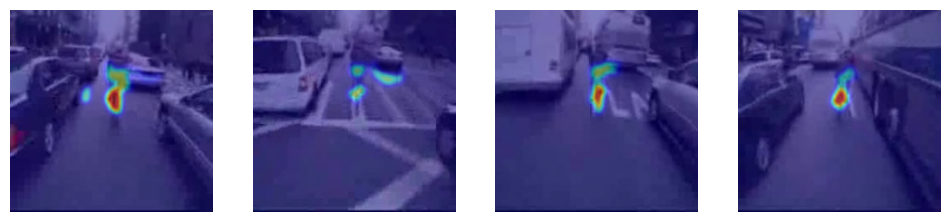

In [ ]:
def classifier_fn(batch):
    """ Classifier function that returns the predictions for the input batch. 
    
    Args:
        batch (np.array): Batch of videos to predict.

    Returns:
        preds (np.array): Predictions for the input batch.
    """
    preds = [] # Put here your call to the classifier
    return np.array(preds)

# Explanation with Video LIME
xai = Xai(video, classifier_fn, ProposedMethods.VideoLIME)
xai.run_pipeline()
plot_frames(xai.exp_vid, n_frames=4)

### Deletion and Preservation Games-based metrics

#### Minimal Mask
For minimal masks evaluation, the goal is to identify the smallest set of regions that either obstruct the network in accurately recognizing the correct class (deletion) or assist the network for the correct classification (preservation). For this, minimal masks at target prediction thresholds are identified with the pixels in the masks counted and expressed as a percentage.

In [ ]:
# Deletion
evaluator = MinMaskEvaluator(video, xai.score_map, classifier_fn, label, method='deletion', hide_color='blur')
results = evaluator.evaluate(ths=[.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9], unique=False, n_samples=200, save_path=save_path)
results

  0%|          | 0/199 [00:00<?, ?it/s]

[1.0,
 1.0,
 0.032157057158801024,
 0.020379763233418367,
 0.00862289740114796,
 0.004047502790178572,
 0.0034849828603316325,
 0.0034159757653061226,
 0.003204470264668367,
 0.0027553013392857145,
 0.0]

In [ ]:
# Insertion
evaluator = MinMaskEvaluator(video, xai.score_map, classifier_fn, label, method='insertion', hide_color='blur')
results = evaluator.evaluate(ths=[.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9], unique=False, n_samples=200, save_path=save_path)
results

  0%|          | 0/199 [00:00<?, ?it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, None]

#### Deletion and insertion AUC
AUC is applied to the prediction confidence as pixels are deleted or preserved. Unlike the minimal masks evaluation, deletion and preservation AUCs do not use a target prediction threshold but rather summarize the results across thresholds. AUC values range between 0 and 1 and should be minimal for deletion (with a minimum value of 0) and maximal for preservation (with a maximum value of 1).

  0%|          | 0/199 [00:00<?, ?it/s]

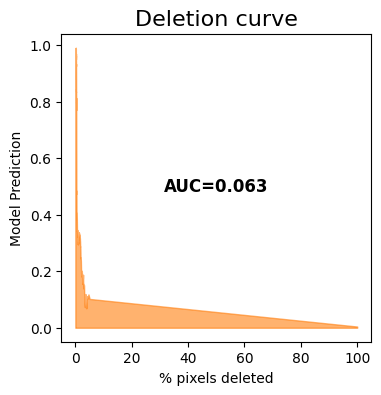

0.06260171090444434

In [ ]:
# Deletion
evaluator = AUCEvaluator(video, xai.score_map, classifier_fn, label, method='deletion', hide_color='blur')
results = evaluator.evaluate(unique=False, n_samples=200, save_path=save_path)

# Plot curve
evaluator.plot_curve(title='Deletion curve')

results

  0%|          | 0/199 [00:00<?, ?it/s]

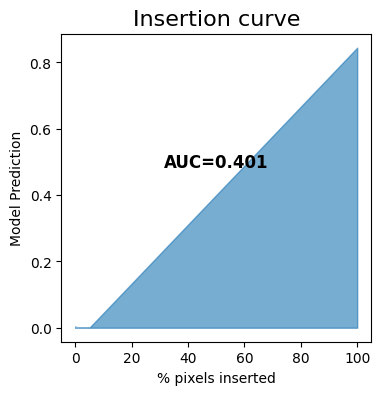

0.4010529500975162

In [ ]:
# Insertion
evaluator = AUCEvaluator(video, xai.score_map, classifier_fn, label, method='insertion', hide_color='blur')
results = evaluator.evaluate(unique=False, n_samples=200, save_path=save_path)

# Plot curve
evaluator.plot_curve(title='Insertion curve')

results

#### Average drop
It measures the average decrease in the prediction when using perturbed and unperturbed video data.  Average drop uses the saliency map to determine the regions to perturb. Regions with more relevance are modestly perturbed, while regions with less relevance are highly perturbed. Only one pass through the network is required. Average drop is minimal for the explanation method to get a good score.

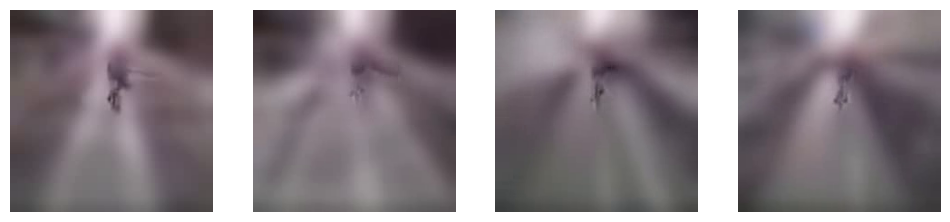

In [ ]:
evaluator = DropEvaluator(video, xai.score_map, classifier_fn, label, hide_color='blur')
results = evaluator.evaluate(save_path=os.path.join(save_path, 'drop.m4v'))
results
plot_frames(load_video(os.path.join(save_path, 'drop.m4v')), n_frames=4)

### Weakly supervized object localization metrics
By extracting regions the model deems crucial, it is possible to build a mask for object detection and segmentation without training on a dataset with such labels. This approach requires a mask or bounding box for ground truth.

In [ ]:
# You can use revex_framework.evaluators.bb_to_mask to convert a bounding box to a mask.
# Here we are loading it directly as a mask.
with np.load('../resources/biking.npz') as data:
    mask = data['box']

# Resize mask
scale_factor = 224 / min(mask.shape[1:3])
video = resize_video(mask, scale_factor, scale_factor, interpolation=cv2.INTER_NEAREST)

# Center crop video
mask = center_crop_video(mask, 224)

#### Pointing Game
determines if the maximum point on the saliency map falls within the ground truth bounding box. If it does, it is considered a hit; otherwise, it is a miss. The localization accuracy is then calculated as $Acc = \frac{\text{\#Hits}}{\text{\#Hits}+\text{\#Misses}}$

True

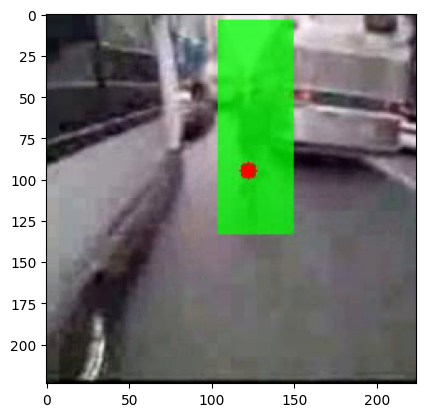

In [ ]:
evaluator = PointingGameEvaluator(video, xai.score_map, method='mask')
results = evaluator.evaluate(mask, save_path=os.path.join(save_path, 'pointing_game.m4v'))
plt.imshow(load_video(os.path.join(save_path, 'pointing_game.m4v'))[64])
results

#### IoU
The intersection over union (IoU) metric can be used with a threshold of (e.g. of 0.5) to evaluate the object localization error for each method, or directly average the IoU for each method, which does not require a threshold. When using a threshold, the saliency maps must be binarized through thresholding.

In [ ]:
th_importance = 0.4 # Threshold used to binarize the importance scores

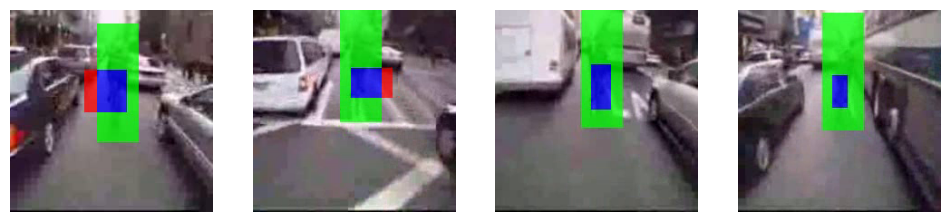

False

In [ ]:
# Using IoU with threshold 0.5
evaluator = IOUEvaluator(video, xai.score_map, method='mask')
results = evaluator.evaluate(mask, save_path=os.path.join(save_path, 'iou-50.m4v'), th_importance=th_importance, to_bb=True, th_iou=0.5)
plot_frames(load_video(os.path.join(save_path, 'iou-50.m4v')), n_frames=4)
results

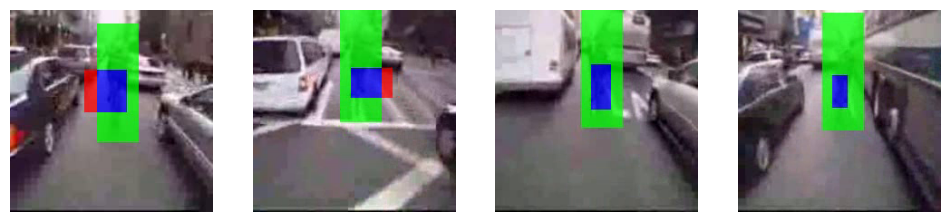

0.16504683537752937

In [ ]:
# Using IoU without threshold
evaluator = IOUEvaluator(video, xai.score_map, method='mask')
results = evaluator.evaluate(mask, save_path=os.path.join(save_path, 'iou-value.m4v'), th_importance=th_importance, to_bb=True)
plot_frames(load_video(os.path.join(save_path, 'iou-value.m4v')), n_frames=4)
results